# Ads CTR Forecasting

## Research course:
- Gathering ad data, including the number of ad impressions (how often an ad was shown), the number of clicks, and any other relevant metrics.
- Exploring the data to understand its characteristics and distribution. Calculate basic statistics, such as the mean CTR (Click-Through Rate) and standard deviation.
- Creating visualizations, such as line charts or bar graphs, to represent CTR trends over time.
- Conducting A/B tests if necessary to compare the performance of different ad variations.
- Analyzing the CTR data to identify factors that influence ad performance.
- Building a forecasting model to predict future CTR values.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from datetime import datetime

data = pd.read_csv('/Users/Илья/Downloads/ctr.csv')
data.head()

,Date,Clicks,Impressions
0,2022-10-19,2851,58598
1,2022-10-20,2707,57628
2,2022-10-21,2246,50135
3,2022-10-22,1686,40608
4,2022-10-23,1808,41999


In [2]:
# Data Preparation
data['Date'] = pd.to_datetime(data['Date'])

Let's visualize the clicks and impressions over time:

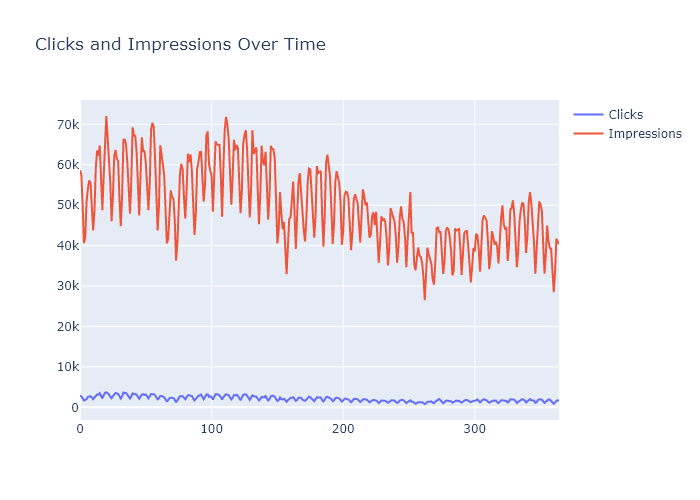

In [3]:
# Visualizing Clicks and Impressions
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Clicks'], mode='lines', name='Clicks'))
fig.add_trace(go.Scatter(x=data.index, y=data['Impressions'], mode='lines', name='Impressions'))
fig.update_layout(title='Clicks and Impressions Over Time')
fig.show(renderer="png")

Now, let’s have a look at the relationship between clicks and impressions:

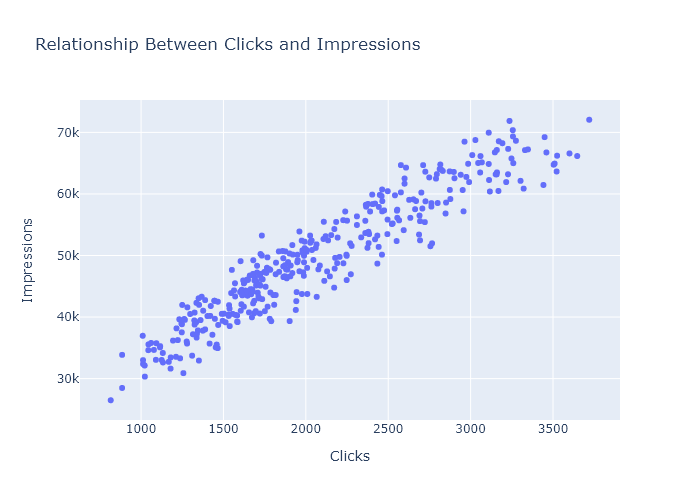

In [4]:
# Creating a scatter plot to visualize the relationship between Clicks and Impressions
fig = px.scatter(data, x='Clicks', y='Impressions', title='Relationship Between Clicks and Impressions',
                 labels={'Clicks': 'Clicks', 'Impressions': 'Impressions'})

fig.update_layout(xaxis_title='Clicks', yaxis_title='Impressions')

fig.show(renderer="png")

So, the relationship between clicks and impressions is linear. It means higher ad impressions result in higher ad clicks. Now, let’s calculate and visualize CTR over time:

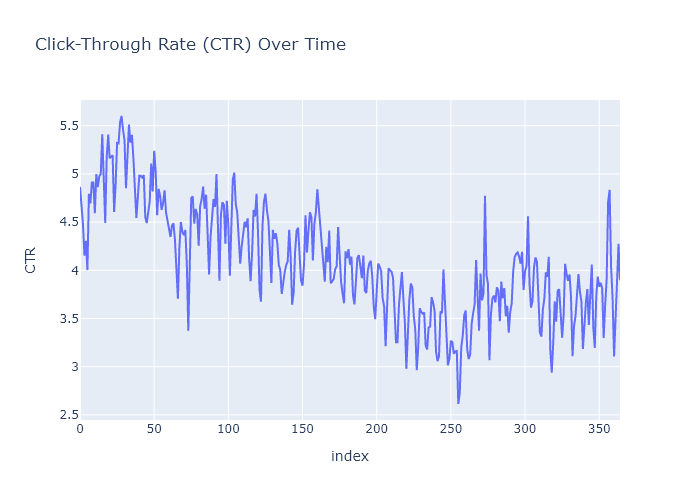

In [5]:
# Calculating and visualizing CTR
data['CTR'] = (data['Clicks'] / data['Impressions']) * 100
fig = px.line(data, x=data.index, y='CTR', title='Click-Through Rate (CTR) Over Time')
fig.show(renderer="png")

Now, let’s have a look at the average CTR by day of the week:

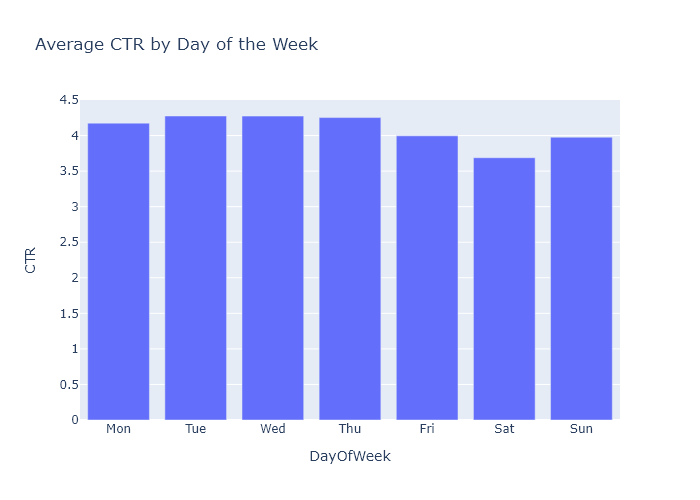

In [6]:
data['DayOfWeek'] = data['Date'].dt.dayofweek

# EDA based on DayOfWeek
day_of_week_ctr = data.groupby('DayOfWeek')['CTR'].mean().reset_index()
day_of_week_ctr['DayOfWeek'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig = px.bar(day_of_week_ctr, x='DayOfWeek', y='CTR', title='Average CTR by Day of the Week')
fig.show(renderer="png")

Now, let’s compare the CTR on weekdays and weekends:

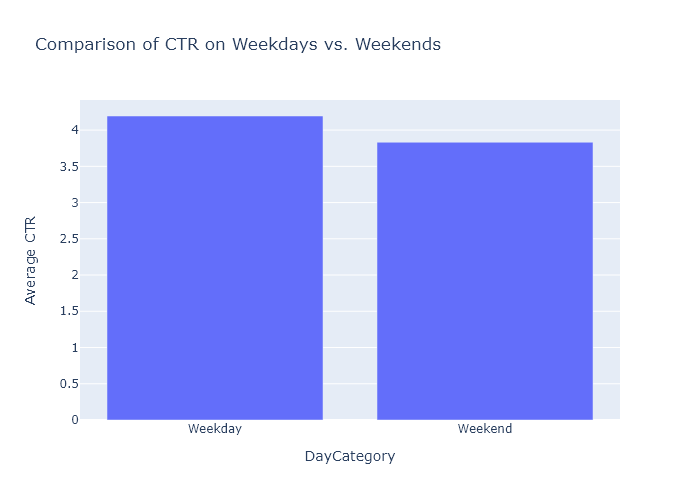

In [7]:
data['DayCategory'] = data['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculate average CTR for weekdays and weekends
ctr_by_day_category = data.groupby('DayCategory')['CTR'].mean().reset_index()

# Create a bar plot to compare CTR on weekdays vs. weekends
fig = px.bar(ctr_by_day_category, x='DayCategory', y='CTR', title='Comparison of CTR on Weekdays vs. Weekends',
             labels={'CTR': 'Average CTR'})

fig.update_layout(yaxis_title='Average CTR')

fig.show(renderer="png")

Let’s compare the impressions and clicks on weekdays and weekends:

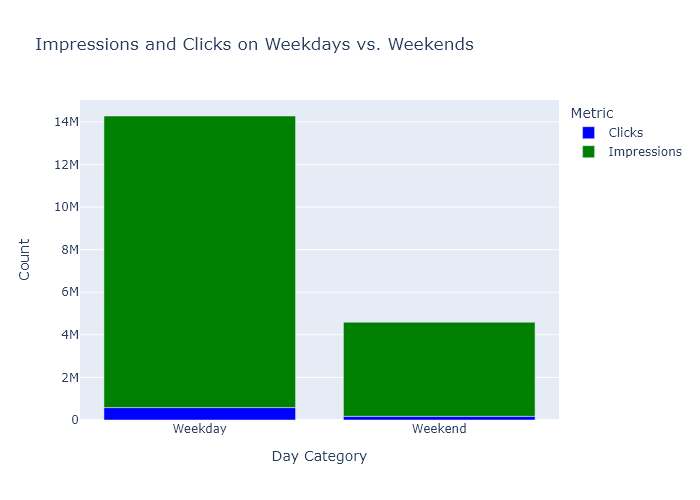

In [8]:
grouped_data = data.groupby('DayCategory')[['Clicks', 'Impressions']].sum().reset_index()

# Creating a grouped bar chart to visualize Clicks and Impressions on weekdays vs. weekends
fig = px.bar(grouped_data, x='DayCategory', y=['Clicks', 'Impressions'],
             title='Impressions and Clicks on Weekdays vs. Weekends',
             labels={'value': 'Count', 'variable': 'Metric'},
             color_discrete_sequence=['blue', 'green'])

fig.update_layout(yaxis_title='Count')
fig.update_xaxes(title_text='Day Category')

fig.show(renderer="png")

## Ads CTR Forecasting

Now, let’s see how to forecast the Ads CTR. As CTR is dependent on impressions and impressions change over time, we can use Time Series forecasting techniques to forecast CTR. As CTR is seasonal, let’s calculate the p, d, and q values for the SARIMA model:

D:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



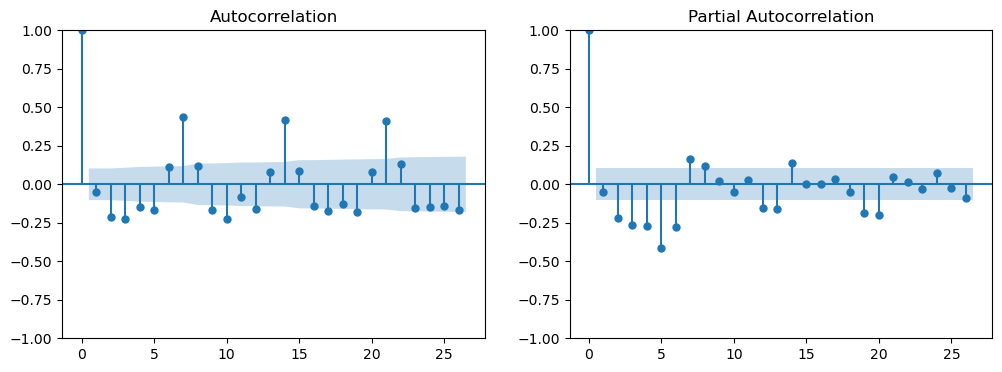

In [10]:
data.reset_index(inplace=True)

# resetting index
time_series = data.set_index('Date')['CTR']

differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

Let’s train the forecasting model using SARIMA:

In [11]:
p, d, q, s = 1, 1, 1, 12

model = SARIMAX(time_series, order=(p, d, q), seasonal_order=(p, d, q, s))
results = model.fit()
print(results.summary())

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                      
Dep. Variable:                                CTR   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -71.365
Date:                            Tue, 16 Jan 2024   AIC                            152.731
Time:                                    22:22:49   BIC                            172.049
Sample:                                10-19-2022   HQIC                           160.419
                                     - 10-18-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5264      0.070      7.509      0.000       0.389       0.664
ma.L1         -0.9048      0.036   

In [12]:
# Predicting future values
future_steps = 100
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
print(predictions)

2023-10-19    3.852384
2023-10-20    3.889523
2023-10-21    3.820403
2023-10-22    3.727730
2023-10-23    3.710625
                ...   
2024-01-22    3.545890
2024-01-23    3.466966
2024-01-24    3.561513
2024-01-25    3.547014
2024-01-26    3.580466
Freq: D, Name: predicted_mean, Length: 100, dtype: float64


Let’s visualize the forecasted trend of CTR:

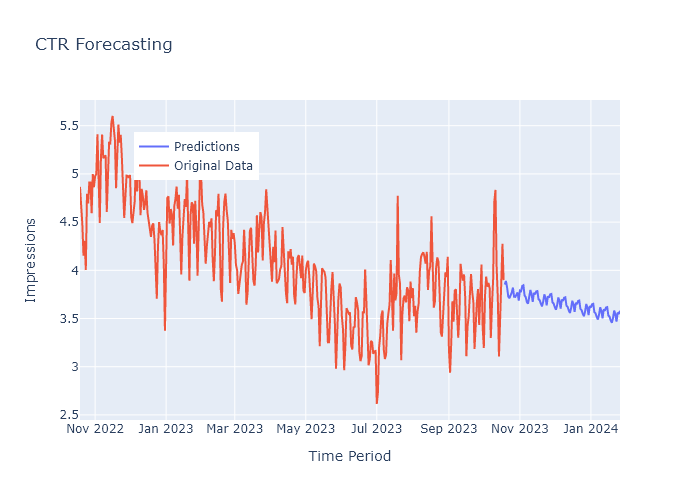

<Figure size 2000x500 with 0 Axes>

In [15]:
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='CTR Forecasting',
                  xaxis_title='Time Period',
                  yaxis_title='Impressions',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show(renderer="png")